#  Revealing mesocale structures of time-varying networks through non-negative tensor factorization

In this notebook we show how the method presented in [[1]](#1) can be applied to data about face-to-face proximity relations collected in a school.

The data were collected by the [SocioPatterns collaboration](http://www.sociopatterns.org) using wearable proximity sensors that sense the face-to-face proximity relations of individuals wearing them. 

A few libraries are required in order to run this notebook. The Python Pandas library is used for data loading and manipulation, the `sktensor` library is used to represent the 3-way tensors and the `ncp` script contains the algorithms for the non-negative tensor factorization.

In [3]:
%pylab inline 

import pandas as pd
import sktensor

Populating the interactive namespace from numpy and matplotlib


In [4]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [5]:
import ncp

In the following we load the expected structures (classes) that are used as a validation for the methodology.

The population of the school consisted of 231 children, organized in 10 classes, and 10 teachers.

In [6]:
classes = pd.read_csv("data/classes.csv", index_col=0, squeeze=True)
print(classes.size)
print(classes.unique() )

241
['cm1a' 'ce2b' 'cm2b' 'cm1b' 'ce1a' 'cm2a' 'teachers' 'cpb' 'ce1b' 'cpa'
 'ce2a']


The data collected through the SocioPatterns platorm is represented as triples $<t, i, j>$ where $i,j$ is a pair of nodes that were in proximity during the interval between time $t$ and $t+20$.

It represents 2 days of activity in a school. We selected only the hours when the kids were at school, for a total of 18 hours (two intervals of 9 hours per day concatenated as a single interval, thus removing the night).

In [7]:
data = pd.read_csv("data/school.csv.gz", compression="gzip")
print(data.head())
print(data.tail())
print(data.shape)

   t  i    j
0  0  0    1
1  0  0    2
2  0  0  222
3  0  1  222
4  0  2  228
            t    i    j
158570  64900  214  217
158571  64900  215  229
158572  64900  215  216
158573  64900  216  225
158574  64900  217  225
(158575, 3)


In [8]:
print( data.t.max() / 3600., "hours")

18.02777777777778 hours


From the timeline that shows the sum of number of contacts for each 20 seconds interval, we see that there is a small interval with no activity between the two 9 hours interval, in order to show where one day ends and starts the other.

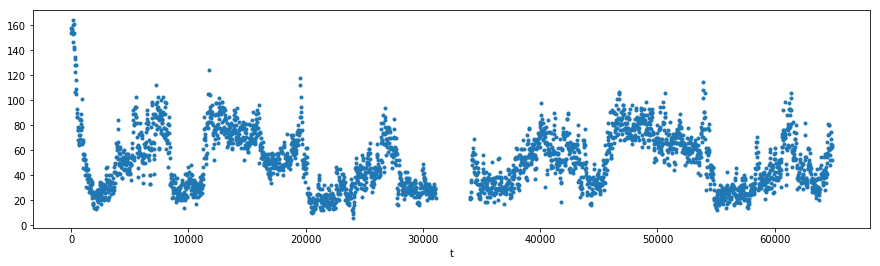

In [9]:
data.groupby(data.t).t.count().plot(linestyle='None', marker='.', figsize=(15,4));

In [10]:
NR_NODES = classes.index.unique().shape[0]
NR_INTERVALS = 150

print(NR_NODES)

241


For the purpose of this experiment, we divide the timeline in 150 different intervals.

In [11]:
data_binned = data.groupby((data.t / ((data.t.max()+1) / float(NR_INTERVALS))).astype(int))
print(data_binned.head(20))
#print(data_binned.shape) #get error

#NOT SURE WHAT THIS DOES, BINS WHAT?

            t   i    j
0           0   0    1
1           0   0    2
2           0   0  222
3           0   1  222
4           0   2  228
5           0   3  232
6           0   3  134
7           0   8   12
8           0   8   13
9           0   9   14
10          0   9   22
11          0  12   75
12          0  12   16
13          0  12   13
14          0  13   22
15          0  13   16
16          0  14   22
17          0  15   87
18          0  15   83
19          0  19   70
3133      440   6   85
3134      440   6   70
3135      440   6   19
3136      440   6   75
3137      440   8   18
3138      440   8   12
3139      440   8   13
3140      440   9   22
3141      440   9   18
3142      440  10   14
...       ...  ..  ...
156246  64040  50   53
156247  64040  56   59
156248  64040  60   64
156249  64040  62   93
156250  64040  63  179
156251  64040  63   64
156252  64040  64  115
156253  64040  69  156
156254  64040  77  127
156255  64040  77  146
157157  64480   5   22
157158  644

In [12]:
def create_adj(g):
    return g.groupby(['i', 'j']).size()

school_adj_series = data_binned.apply(create_adj)
school_adj_series.head(20)

t  i  j  
0  0  1      15
      2      15
      222    15
   1  219     4
      222    15
   2  219     4
      228    15
      231     2
   3  134     6
      232     6
   4  134     1
      233     1
   6  12      4
      19      4
      65      1
      70      2
      75      5
      85      5
   8  12     19
      13     20
dtype: int64

We transform the $<t, i, j>$ triples in a 3-way binary tensor.

In [13]:
triples = array([(i, j, t) for t, i, j in school_adj_series.keys()] + 
                [(j, i, t) for t, i, j in school_adj_series.keys()])

print(triples[1:10], triples[-10:-1])

X = sktensor.sptensor(tuple(triples.T), ones(len(triples)),
                      shape=(NR_NODES, NR_NODES, NR_INTERVALS))

print(X.shape)

[[  0   2   0]
 [  0 222   0]
 [  1 219   0]
 [  1 222   0]
 [  2 219   0]
 [  2 228   0]
 [  2 231   0]
 [  3 134   0]
 [  3 232   0]] [[227 221 149]
 [227 225 149]
 [229 225 149]
 [229 227 149]
 [175 235 149]
 [182 235 149]
 [183 235 149]
 [ 90 236 149]
 [195 238 149]]
(241, 241, 150)


The tensor is factorized using the alternating non-negative least squares algorithm with the block principal pivoting method, proposed in [[2]](#2).

In [14]:
np.random.seed(4)

X_approx_ks = ncp.nonnegative_tensor_factorization(X, 14, method='anls_bpp')

In [ ]:
nWay = len(X.shape)
print(nWay)

orderWays = np.arange(nWay)
print(orderWays)

print(range(nWay))
print('Finit = F_cell = (241,14), (241,14), (150, 14)')

Finit = [np.random.rand(X.shape[i], 14) for i in range(nWay)]
F_cell = Finit

print('what is inputted into getGradient(X, F_cell=random nums btw 0,1 is specific shape, nWay=3, r=14)')

In [ ]:
ways = range(nWay)
print(ways)

    
#for i in [0, 1, 2, 3]:
#    print(i)

#for i in range(nWay):
#    print(i)
    
def gG(nWay):
    for k in range(nWay):
        ways2 = [i for i in range(nWay) if i != k] 
        print(ways2)
        #for i in ways:
        #    print(i)
        
gG(3)

The result of the factorization is a set of loading matrices $\mathbf{A, B, C}$.

In [16]:
A = X_approx_ks.U[0]
B = X_approx_ks.U[1]
C = X_approx_ks.U[2]

print(A, B, C)

[[9.07535840e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.40932905e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.52796961e-05
  0.00000000e+00 0.00000000e+00]
 [1.11406775e-04 1.55535987e-04 0.00000000e+00 ... 4.97261015e-04
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.92276189e-03 1.05480128e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.49163167e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] [[1.23369376e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.65521988e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.11251276e-03
  0.00000000e+00 0.00000000e+00]
 [1.51647660e-02 1.86650951e-02 0.00000000e+00 ... 1.00454945e-01
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]

We then group the rows of $\mathbf{A}$ by class and sum the values, in order to check how much of each class is represented in each one of the factors.

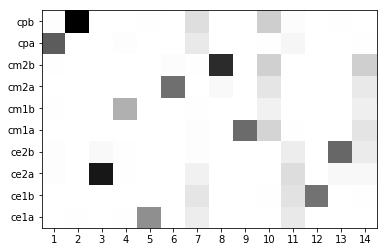

In [17]:
dfa = pd.DataFrame(A).groupby(classes).sum()
dfa = dfa[dfa.index!='teachers']

plt.pcolormesh(dfa.values, cmap=plt.cm.Greys)
plt.xlim(0, dfa.shape[1])
plt.yticks(arange(10)+0.5, dfa.index)
plt.xticks(arange(14)+0.5, arange(1,15));

The activity timeline of each factor is represented in $\mathbf{C}$.

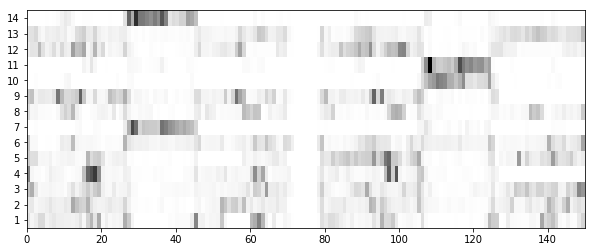

In [18]:
figure(figsize=(10,4))
plt.pcolormesh(C.T, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(arange(14)+0.5, arange(1,15));

We can also reorder the factors to show better the results of the factorization.

In [19]:
factor_order = [1, 0, 7, 5, 3, 8, 12, 2, 11, 4, 6, 13, 9, 10]

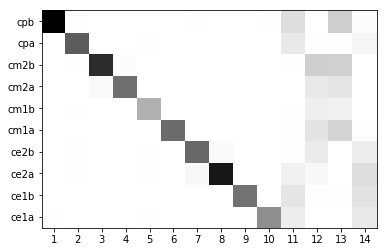

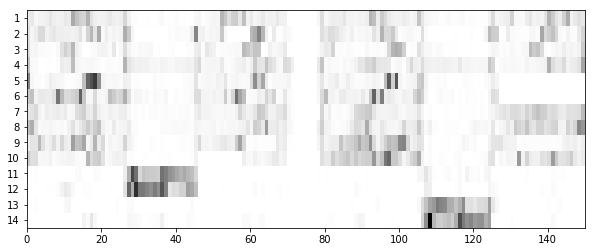

In [20]:
dfa = pd.DataFrame(A).groupby(classes).sum()
dfa = dfa[dfa.index!='teachers']

figure()
plt.pcolormesh(dfa.values[:, factor_order], cmap=plt.cm.Greys)
plt.xlim(0, dfa.shape[1])
plt.yticks(arange(10)+0.5, dfa.index)
plt.xticks(arange(14)+0.5, arange(1,15));

figure(figsize=(10,4))
plt.pcolormesh(C[:, factor_order[::-1]].T, cmap=plt.cm.Greys)
plt.xlim(0, C.shape[0])
plt.yticks(arange(14)+0.5, arange(14,0,-1));

References:

<a name="1"></a>[1] L. Gauvin, A. Panisson, C. Cattuto. [Detecting the Community Structure and Activity Patterns of Temporal Networks: A Non-Negative Tensor Factorization Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086028#pone-0086028-g001) PLOS ONE 9.1 (2014): e86028.

<a name="2"></a> [2] Kim J, Park H (2012) Fast nonnegative tensor factorization with an active-set-like method. In: Berry MW, Gallivan KA, Gallopoulos E, Grama A, Philippe B, et al., editors, High-Performance Scientific Computing, Springer London. 311–326.